### Importing Data

In [2]:
import pandas as pd
#import keras
import pandas.plotting
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\LouD\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
from pylab import mpl, plt
plt.style.use('seaborn')
!pip install yfinance
import yfinance as yf

In [4]:
#Defines the ticker symbols and dates to pull data for
symbols = ['LUV']
start = '2001-01-01'
end = '2021-06-03'

In [5]:
#create the DF and pull in only the Adjusted Close for specified ticker
df = pd.DataFrame()
for s in symbols:
    df[s] = yf.download(s,start,end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
#Column does not have a name, so name it
df.rename(columns={ df.columns[0] : 'Adj Close'}, inplace=True)

Simple Moving Averages smooth the price trends and remove noise from the series. When asset prices move over their SMA (cross-over), it may indicate a trading signal. Using a shorter term MA with a longer term MA is known as a "golden cross". Investors watch for shorter term to cross above the longer term for their buy signal. When the shorter term crosses under the longer term, it's a sell signal.

In [7]:
# Set the timeframe for the Simple Moving Averages (42 days and 252 days)
SMA1 = 42  
SMA2 = 252

In [8]:
# Create SMA columns and perform the calculations
df['SMA1'] = df['Adj Close'].rolling(SMA1).mean()  
df['SMA2'] = df['Adj Close'].rolling(SMA2).mean()

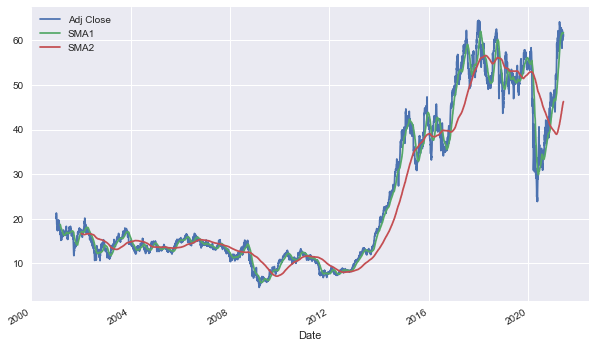

In [9]:
df.plot(figsize=(10, 6))

In [10]:
df.dropna(inplace=True)

In [11]:
# Check where the short term MA is greater than longe term MA, mark those with a 1 and others with -1
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [12]:
df.sample(10)

,Adj Close,SMA1,SMA2,Position
Date,,,,
2020-09-03,38.740002,34.243095,44.003120,-1
2019-10-18,53.102085,52.968040,51.461362,1
2007-12-11,12.553367,12.844075,13.783665,-1
2010-05-13,11.953326,12.251619,9.232317,1
2011-01-03,12.293284,12.351645,11.560147,1
2020-09-08,40.500000,34.610476,43.905554,-1
2005-08-09,12.760865,12.999416,13.495569,-1
2008-07-17,13.846611,12.500846,12.527656,-1
2012-02-09,9.099627,8.320058,9.295030,-1


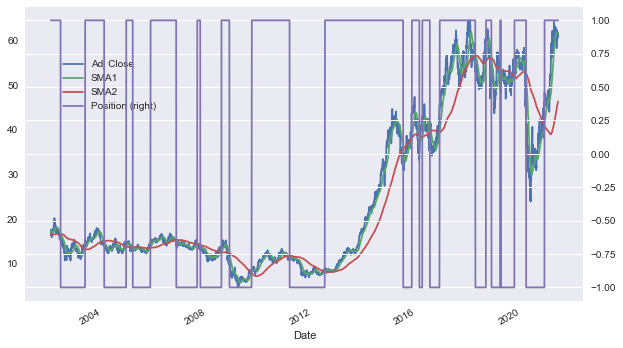

In [13]:
ax = df.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

In [14]:
# Calculate the log returns for investment (benchmark)
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [15]:
#
df['Strategy'] = df['Position'].shift(1) * df['Returns']

In [16]:
df.dropna(inplace=True)

In [17]:
#df.columns = pd.MultiIndex.from_tuples(map(lambda x: ('LUV', x[1]), df.columns))
df.head()

,Adj Close,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2002-01-08,17.264807,17.055187,16.690709,1,-0.018398,-0.018398
2002-01-09,16.797701,17.069247,16.677823,1,-0.027428,-0.027428
2002-01-10,16.495453,17.077854,16.659162,1,-0.018157,-0.018157
2002-01-11,16.284790,17.092564,16.639302,1,-0.012853,-0.012853
2002-01-14,16.174877,17.112942,16.621184,1,-0.006772,-0.006772


In [18]:
#df.columns = pd.MultiIndex.from_tuples(map(lambda x: (x[0], 'E', x[1]), df.columns))
df.head()

,Adj Close,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2002-01-08,17.264807,17.055187,16.690709,1,-0.018398,-0.018398
2002-01-09,16.797701,17.069247,16.677823,1,-0.027428,-0.027428
2002-01-10,16.495453,17.077854,16.659162,1,-0.018157,-0.018157
2002-01-11,16.284790,17.092564,16.639302,1,-0.012853,-0.012853
2002-01-14,16.174877,17.112942,16.621184,1,-0.006772,-0.006772


### Random Forest Model

In [19]:
forest_df = df.copy()
forest_df.head()

,Adj Close,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2002-01-08,17.264807,17.055187,16.690709,1,-0.018398,-0.018398
2002-01-09,16.797701,17.069247,16.677823,1,-0.027428,-0.027428
2002-01-10,16.495453,17.077854,16.659162,1,-0.018157,-0.018157
2002-01-11,16.284790,17.092564,16.639302,1,-0.012853,-0.012853
2002-01-14,16.174877,17.112942,16.621184,1,-0.006772,-0.006772


In [20]:
x_var_list = ['Adj Close', 'SMA1', 'SMA2']

forest_df[x_var_list].tail()

,Adj Close,SMA1,SMA2
Date,,,
2021-05-26,61.209999,61.652142,45.805754
2021-05-27,61.730000,61.670476,45.921548
2021-05-28,61.459999,61.659762,46.038055
2021-06-01,61.349998,61.666666,46.148095
2021-06-02,60.869999,61.656428,46.252817


In [21]:
training_start = forest_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2014-01-04'

# Construct testing start and end dates
testing_start =  '2014-01-05'
testing_end = forest_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2002-01-08
Training End: 2014-01-04
Testing Start: 2014-01-05
Testing End: 2021-06-02


In [22]:
x_train = forest_df[x_var_list][training_start:training_end]
y_train = forest_df['Position'][training_start:training_end]

In [23]:
x_test = forest_df[x_var_list][testing_start:testing_end]
y_test = forest_df['Position'][testing_start:testing_end]

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [25]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Position,Predicted Value
Date,,
2014-01-06,1,1
2014-01-07,1,1
2014-01-08,1,1
2014-01-09,1,1
2014-01-10,1,1
...,...,...
2021-05-26,1,1
2021-05-27,1,1
2021-05-28,1,1


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[   0,  700],
       [   0, 1165]], dtype=int64)

In [27]:

from sklearn.metrics import classification_report
target_names = ['Sell', 'Buy']
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

        Sell       0.00      0.00      0.00       700
         Buy       0.62      1.00      0.77      1165

    accuracy                           0.62      1865
   macro avg       0.31      0.50      0.38      1865
weighted avg       0.39      0.62      0.48      1865



C:\Users\LouD\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LouD\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LouD\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
